In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16117, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 16117 (delta 9), reused 11 (delta 1), pack-reused 16089
Receiving objects: 100% (16117/16117), 14.85 MiB | 20.46 MiB/s, done.
Resolving deltas: 100% (11028/11028), done.
/content/yolov5


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.1.0+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


# Download Correctly Formatted Custom Dataset

We'll download our dataset from Roboflow. Use the "**YOLOv5 PyTorch**" export format.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [ ]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow

In [ ]:
%cd /content/yolov5

from roboflow import Roboflow
# Masukkan api key pada dataset
rf = Roboflow(api_key="31MpCMP9HtPXoR45vygC")
project = rf.workspace("nothing-e8fii").project("plate_labels2")
dataset = project.version(1).download("yolov5")

/content/yolov5
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to plate_labels2-1 in yolov5pytorch:: 100%|██████████| 1104/1104 [00:00<00:00, 4092.01it/s]


In [ ]:
!curl -L "https://public.roboflow.com/ds/K9IjAYLk5y?key=9th6uXdcDR" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat plate_labels2-1/data.yaml

names:
- K1
- K2
- K3
- K4
nc: 4
roboflow:
  license: CC BY 4.0
  project: plate_labels2
  url: https://universe.roboflow.com/nothing-e8fii/plate_labels2/dataset/1
  version: 1
  workspace: nothing-e8fii
test: ../test/images
train: plate_labels2-1/train/images
val: plate_labels2-1/valid/images


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [ ]:
# define number of classes based on YAML
import yaml
with open("plate_labels2-1/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
num_classes

'4'

In [ ]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5m.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5m.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 32 --epochs 500 --data 'plate_labels2-1/data.yaml' --cfg ./models/custom_yolov5m.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2023-12-25 15:00:22.060854: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-25 15:00:22.060910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-25 15:00:22.062259: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=, cfg=./models/custom_yolov5m.yaml, data=plate_labels2-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=500, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, opti

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

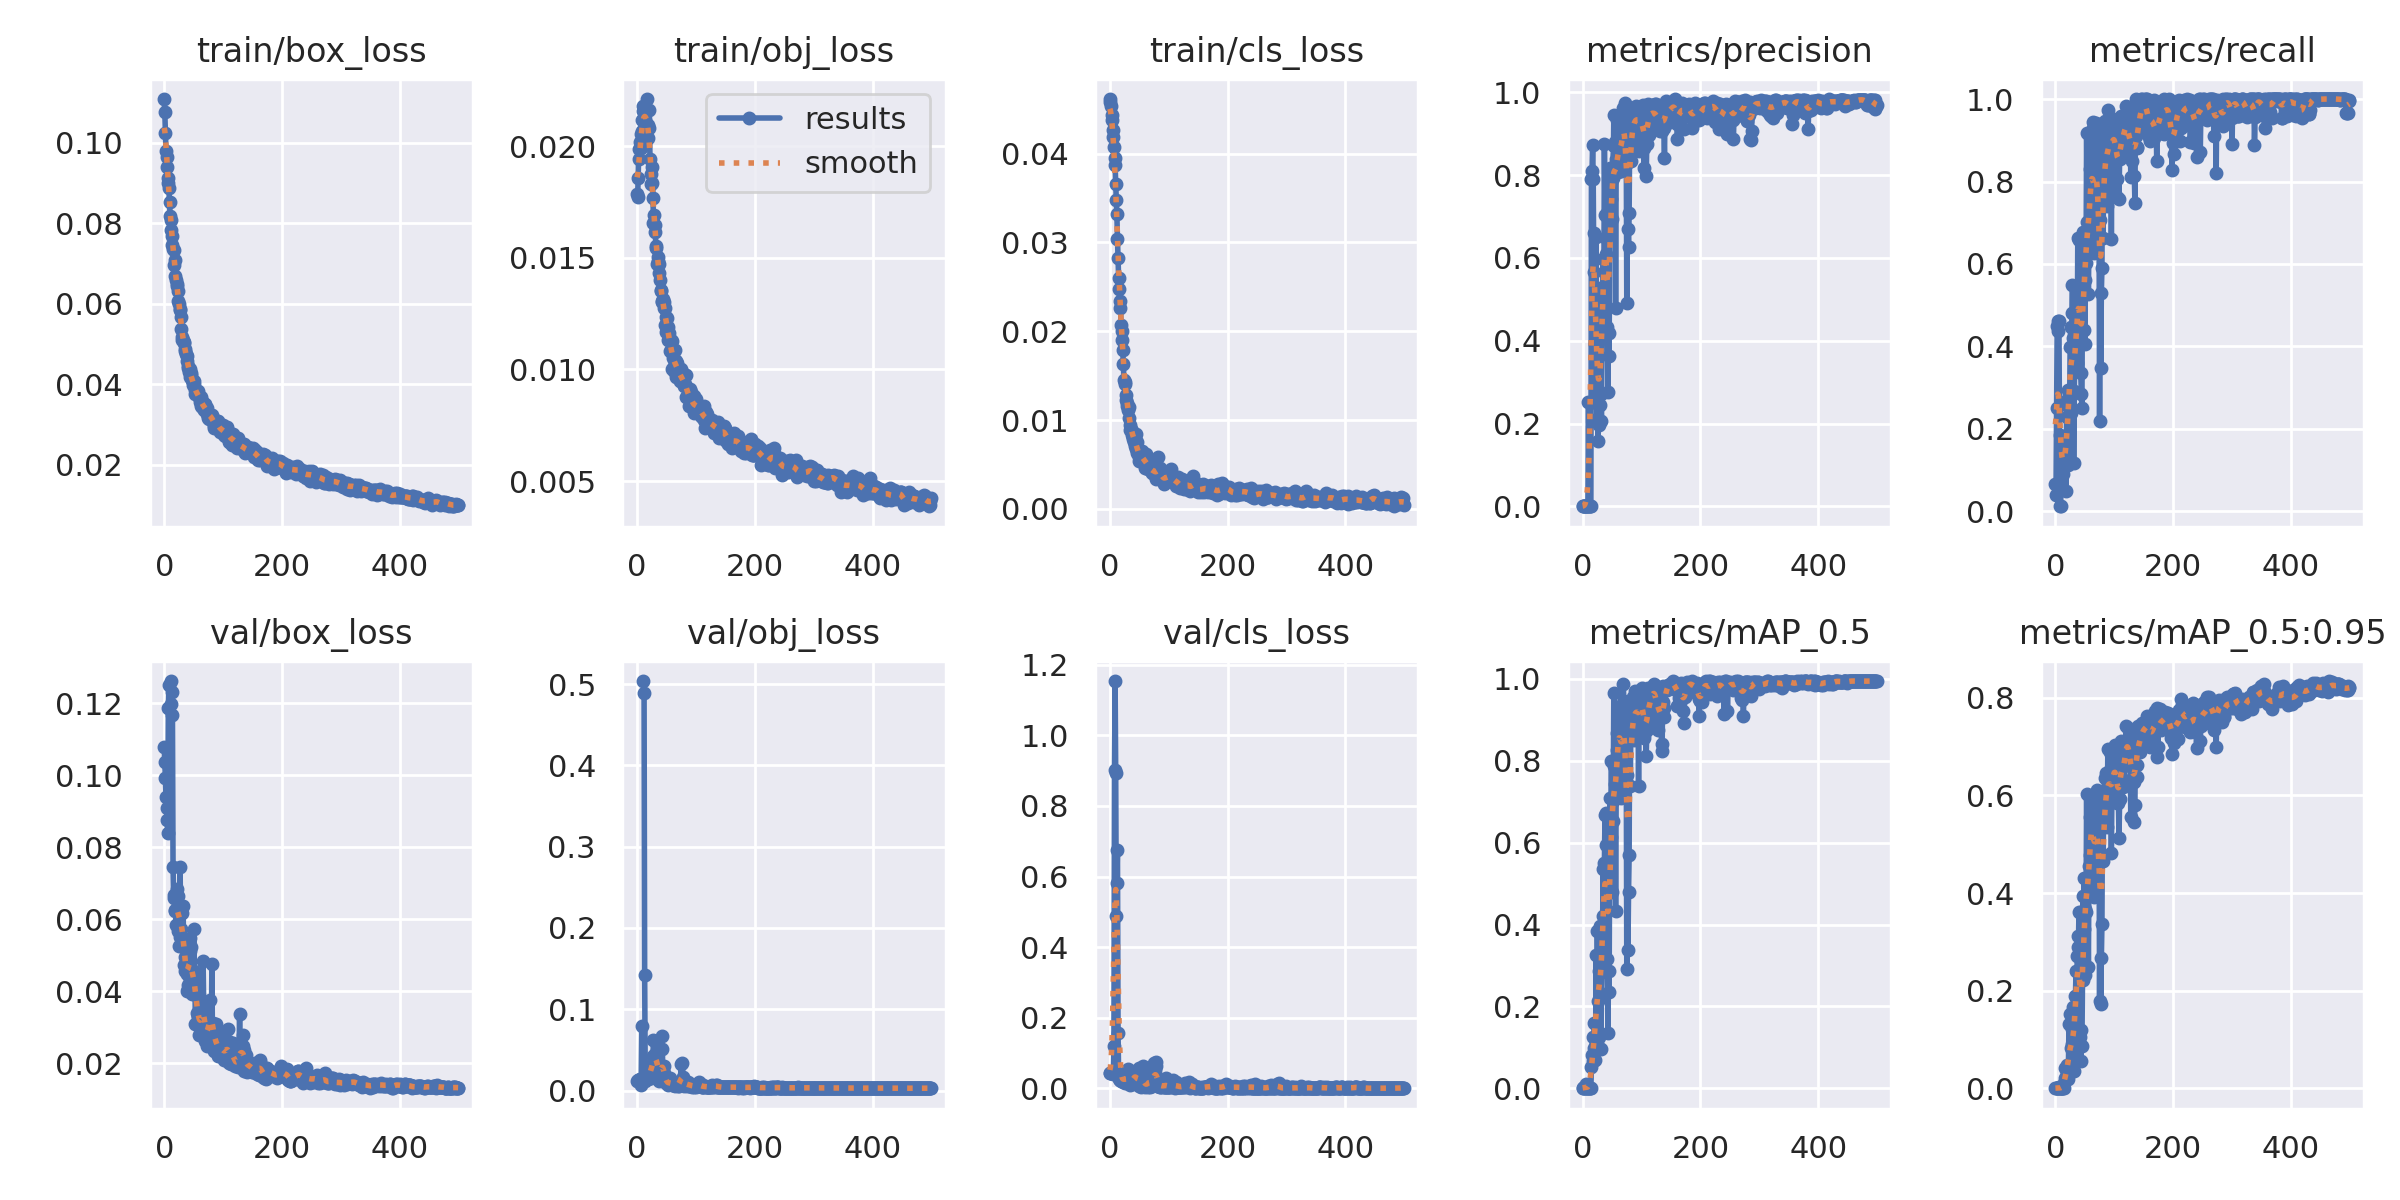

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_pred.jpg', width=900)

In [ ]:
# next, display our predicted label data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch1.jpg', width=900)



#Save The custom Trained Model
Hasilnya dapat di download di direktori /content/yolov5 pada google colab



In [ ]:
!python export.py --weights best.pt --include torchscript onnx

export: data=data/coco128.yaml, weights=['best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-254-gba63208 Python-3.10.12 torch-2.1.0+cu121 CPU

Fusing layers... 
custom_YOLOv5m summary: 182 layers, 7254609 parameters, 0 gradients

PyTorch: starting from best.pt with output shape (1, 25200, 9) (14.1 MB)

TorchScript: starting export with torch 2.1.0+cu121...
TorchScript: export success ✅ 4.3s, saved as best.torchscript (28.2 MB)

ONNX: starting export with onnx 1.15.0...
ONNX: export success ✅ 1.3s, saved as best.onnx (28.1 MB)

Export complete (6.6s)
Results saved to /content/yolov5
Detect:          python detect.py --weights best.onnx 
Validate:        python val.py --weights best.onnx 


#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [ ]:
%cd /content/yolov5/

/content/yolov5


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source plate_labels2-1/test/images

/content/yolov5
detect: weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'], source=plate_labels2-1/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-253-g63555c8 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5m summary: 182 layers, 7254609 parameters, 0 gradients
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/111 /content/yolov5/plate_labels2-1/test/images/K1_A2522VAZ_jpg.rf.281c64cac4f16962b5a30741bdf8b01d.jpg: 416x320 1 K1, 47.7ms
image 2/111 /content/yolov5/plate_labels2-1/test/images/K1_AA5155RG_jpg.rf.0c0a644dd061c3390e69e212bca33e65

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/My\ Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Future inference(testing)

In Future, if we want to test our trained model(best.pt) with the unseen image then you can do with just one line of below code.

In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source "/content/drive/MyDrive/Tugas/Dataset Plat Nomor/K1"

/content/yolov5
detect: weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'], source=/content/drive/MyDrive/Tugas/Dataset Plat Nomor/K1, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-253-g63555c8 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5m summary: 182 layers, 7254609 parameters, 0 gradients
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/198 /content/drive/MyDrive/Tugas/Dataset Plat Nomor/K1/K1_4901KW.jpg: 416x320 1 K1, 47.0ms
image 2/198 /content/drive/MyDrive/Tugas/Dataset Plat Nomor/K1/K1_A2522VAZ.jpg: 416x320 1 K1, 6.8ms
image 3/198 /conten

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

## To save bounding box coordinate in text file

In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use --save txt
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source "/content/drive/MyDrive/Tugas/Dataset Plat Nomor/K4" --save-txt

/content/yolov5
detect: weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'], source=/content/drive/MyDrive/Tugas/Dataset Plat Nomor/K4, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-253-g63555c8 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5m summary: 182 layers, 7254609 parameters, 0 gradients
image 1/63 /content/drive/MyDrive/Tugas/Dataset Plat Nomor/K4/K4_1253VAA.jpg: 416x256 1 K4, 50.9ms
image 2/63 /content/drive/MyDrive/Tugas/Dataset Plat Nomor/K4/K4_A1036PM.jpg: 416x256 1 K4, 7.3ms
image 3/63 /content/drive/MyDrive/Tugas/Dataset Plat Nomor/K4/K4

## To crop the object in the bounding box..

added some additional code in detect.py file...

In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use --save crop
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source "/content/drive/MyDrive/Tugas/Dataset Plat Nomor/K4" --save-crop

/content/yolov5
detect: weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'], source=/content/drive/MyDrive/Tugas/Dataset Plat Nomor/K4, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-253-g63555c8 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5m summary: 182 layers, 7254609 parameters, 0 gradients
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/63 /content/drive/MyDrive/Tugas/Dataset Plat Nomor/K4/K4_1253VAA.jpg: 416x256 1 K4, 81.9ms
image 2/63 /content/drive/MyDrive/Tugas/Dataset Plat Nomor/K4/K4_A1036PM.jpg: 416x256 1 K4, 9.4ms
image 3/63 /content/dr

## Display cropped image from the bounding box

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp4/crops/K1/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [ ]:
# save cropped plate
!zip -r /content/crop_k4.zip /content/yolov5/runs/detect/exp10/crops

  adding: content/yolov5/runs/detect/exp10/crops/ (stored 0%)
  adding: content/yolov5/runs/detect/exp10/crops/K2/ (stored 0%)
  adding: content/yolov5/runs/detect/exp10/crops/K2/K4_AB1544EN.jpg (deflated 0%)
  adding: content/yolov5/runs/detect/exp10/crops/K3/ (stored 0%)
  adding: content/yolov5/runs/detect/exp10/crops/K3/K4_B2823SJH.jpg (deflated 1%)
  adding: content/yolov5/runs/detect/exp10/crops/K3/K4_AB1554EE.jpg (deflated 0%)
  adding: content/yolov5/runs/detect/exp10/crops/K3/K4_AB1790SU.jpg (deflated 0%)
  adding: content/yolov5/runs/detect/exp10/crops/K4/ (stored 0%)
  adding: content/yolov5/runs/detect/exp10/crops/K4/K4_1253VAA.jpg (deflated 4%)
  adding: content/yolov5/runs/detect/exp10/crops/K4/K4_AD1384ED.jpg (deflated 2%)
  adding: content/yolov5/runs/detect/exp10/crops/K4/K4_AB1810XP.jpg (deflated 0%)
  adding: content/yolov5/runs/detect/exp10/crops/K4/K4_B1386PK.jpg (deflated 5%)
  adding: content/yolov5/runs/detect/exp10/crops/K4/K4_AB1379GN.jpg (deflated 1%)
  addin